# Generate datasets to train CNNs to identify number of layers in the time domain

In [1]:
import torch
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
from Simulate import simulate_reference, simulate_parallel

c = 299792458   


def downsample_tensor(tensor, factor):
    """
    Downsamples a 1D tensor by the given factor by taking every nth sample.
    
    Args:
        tensor (torch.Tensor): The input 1D tensor.
        factor (int): The downsampling factor.
        
    Returns:
        torch.Tensor: The downsampled tensor.
    """
    if len(tensor.shape) != 1:
        raise ValueError("Input tensor must be 1D")
    return tensor[::factor]

In [2]:
from multiprocessing import cpu_count

print(f'workers available: {cpu_count()}')

workers available: 11


## Define reference and test downsampling

[((3.46+0.01j), 0.001), ((2.5+0.015j), 0.0005)]


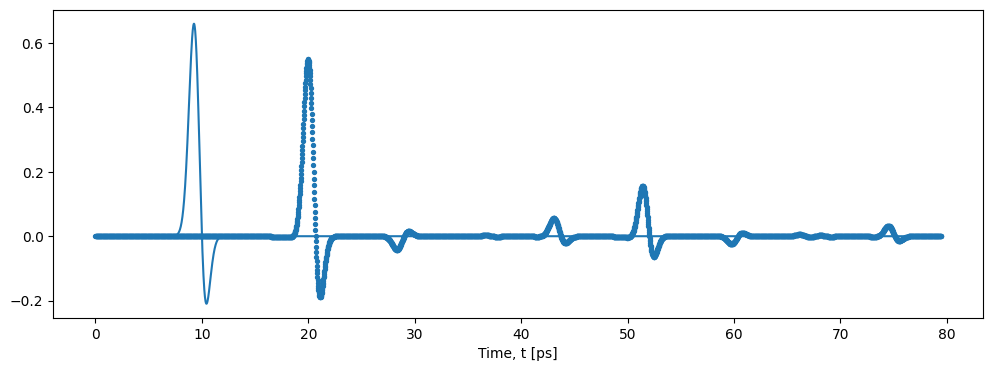

In [3]:
# Define Example parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 1e-3
n2, k2, d2= 2.5, 0.015, 0.5e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]

#material_params_exp = [(2.623310429957411+0.05097939852830086j, 0.0007832302756899971), (4.7038775164516995+0.048144427509738213j,0.0003920638335560057), (5.885909082057244-0.061052689387600695j, 0.00045142062979365945)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]
experimental_pulse = experimental_pulse.detach().cpu()

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.scatter(t_axis*1e12, experimental_pulse, s=8)
plt.xlabel('Time, t [ps]')
plt.show()

In [4]:
# Example usage
downsampled_pulse = downsample_tensor(experimental_pulse, 4)

print("Original shape:", experimental_pulse.shape)
print("Downsampled shape:", downsampled_pulse.shape)

Original shape: torch.Size([4096])
Downsampled shape: torch.Size([1024])


In [5]:
t_axis_downsample = np.arange(0, L * deltat, deltat*4)

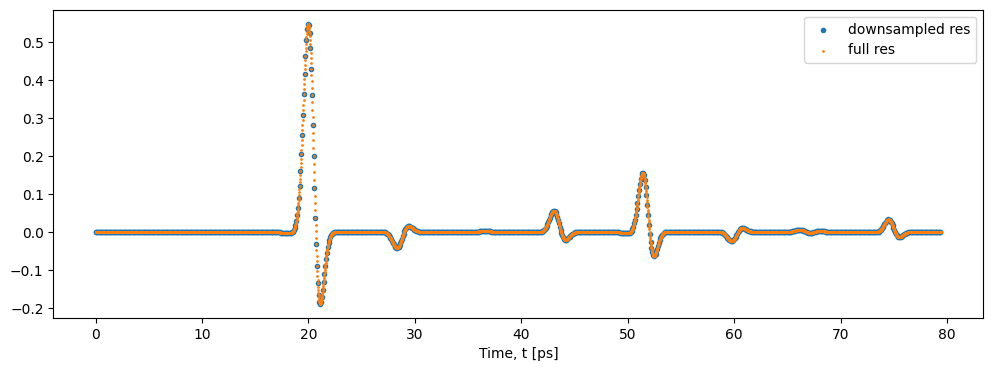

In [6]:
plt.figure(figsize=(12,4))
plt.scatter(t_axis_downsample*1e12, downsampled_pulse, label='downsampled res', s=9)
plt.scatter(t_axis*1e12, experimental_pulse, label='full res', s=1)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [7]:
print(len(experimental_pulse))
print(f'exp_pulse type:{type(experimental_pulse)}')
print(f'ref_pulse type:{type(reference_pulse)}')

4096
exp_pulse type:<class 'torch.Tensor'>
ref_pulse type:<class 'torch.Tensor'>


## Now run Data_gen_efficient.py to get data 

In [8]:
# Load the dataset with weights_only=False
data = torch.load("synthetic_data.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

Dataset loaded successfully!
Number of samples: 10000
Shape of synthetic_data: torch.Size([10000, 1024])
Shape of num_layers: torch.Size([10000])
Example number of layers: tensor([2, 1, 1, 1, 1, 2, 3, 2, 1, 2])


In [9]:
import os
file_path = 'synthetic_data.pt'
file_size = os.path.getsize(file_path)

file_size_MB = file_size / (1024*1024)

print(f'File size: {file_size_MB:.2f} MB')

File size: 41.60 MB


## Collect data, plot vs simulations to verify labels

Num layers: 3
Material parameters: [((3.948914336684361-0.08486019116089366j), 0.000334733046366493), ((1.8239967301027464-0.06705321456040031j), 0.0003837159175006641), ((2.9383460497188976-0.0696921023730447j), 5.449735429693968e-05)]


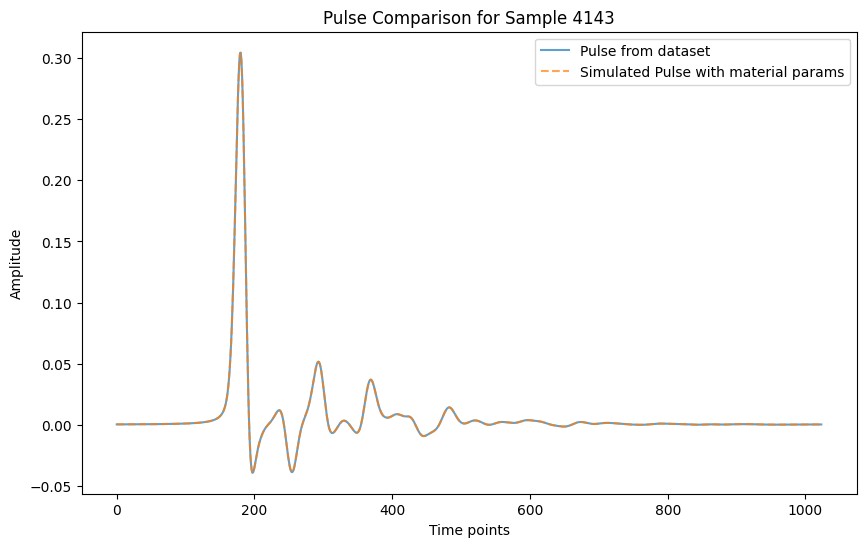

Sample 4143 comparison complete.
Num layers: 1
Material parameters: [((5.40298117417594-0.08311409341645874j), 8.836609594906454e-05)]


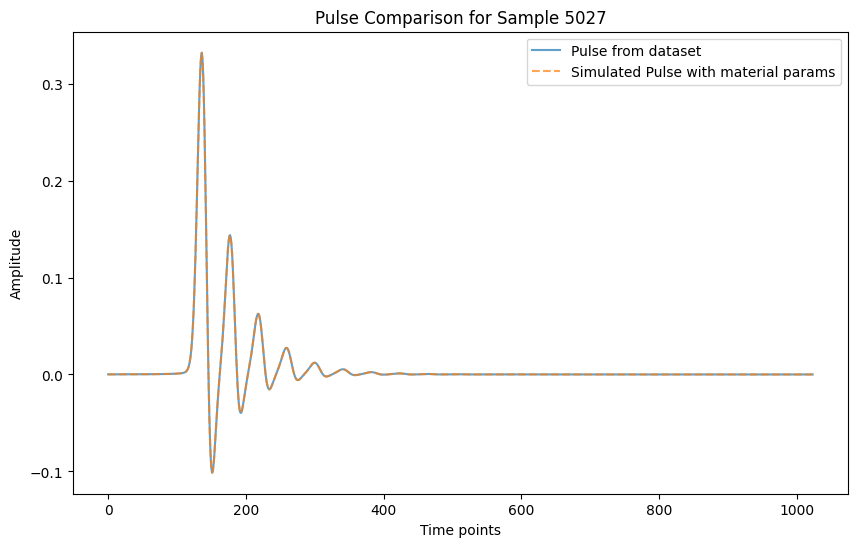

Sample 5027 comparison complete.
Num layers: 1
Material parameters: [((3.29383410581083-0.06733870578028664j), 0.00028100283218335004)]


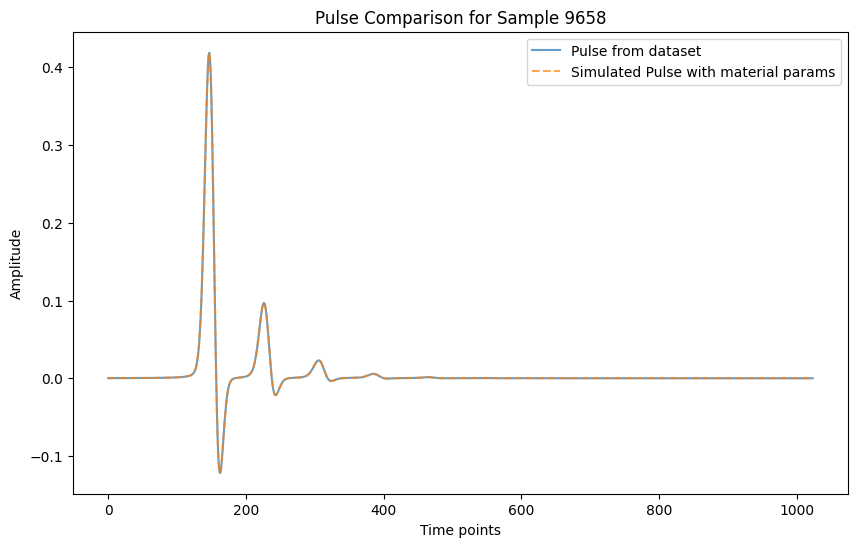

Sample 9658 comparison complete.
Num layers: 1
Material parameters: [((4.519107725543053-0.010200671654136462j), 0.00011156353046868237)]


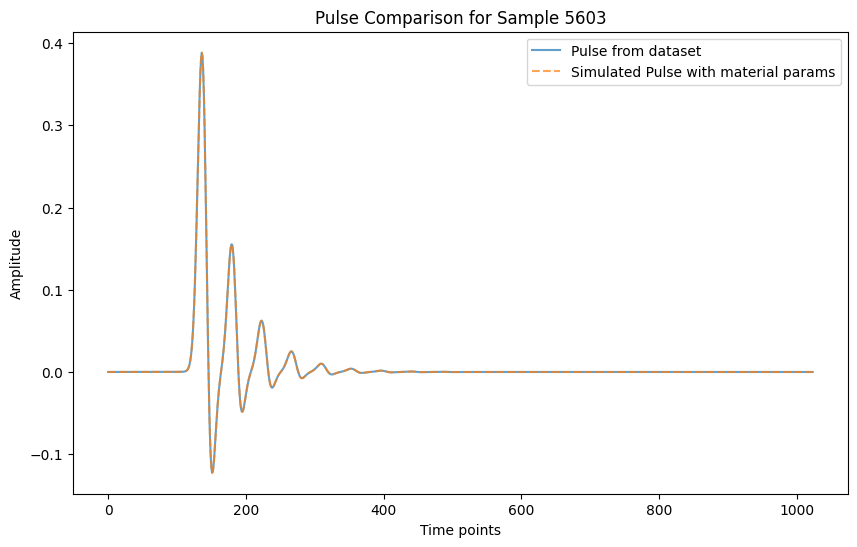

Sample 5603 comparison complete.
Num layers: 1
Material parameters: [((1.8381560998491526-0.04641134368955355j), 0.0001389923088586288)]


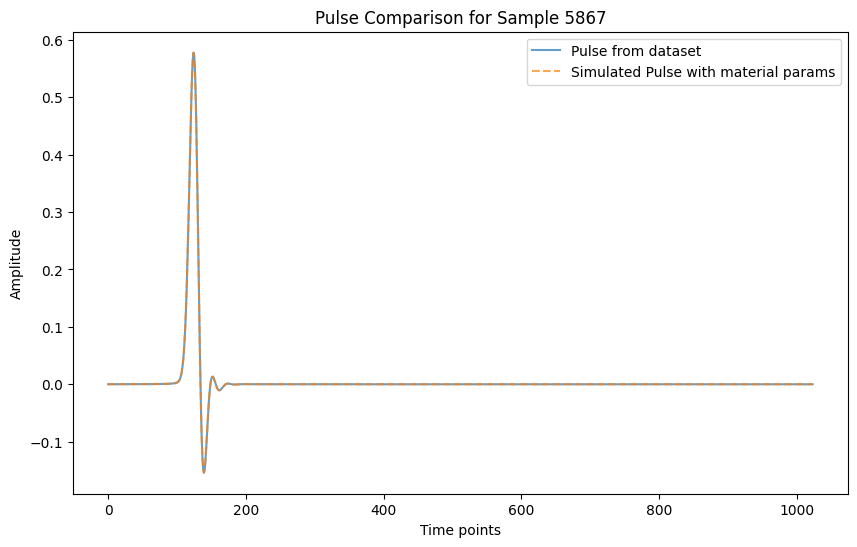

Sample 5867 comparison complete.


In [10]:
# Sample 5 random datapoints
num_samples = len(synthetic_data)
random_indices = np.random.choice(num_samples, 5, replace=False)

# Plot the pulses and compare them
for idx in random_indices:
    # Get the material parameters and the reference pulse for this sample
    material_sample = material_params[idx]
    print(f'Num layers: {len(material_sample)}')
    print(f'Material parameters: {material_sample}')
    # Simulate the pulse with the material parameters
    simulated_pulse = simulate_parallel(reference_pulse, material_sample, deltat, 0)[1].detach().cpu()[:L]
    simulated_pulse = downsample_tensor(simulated_pulse, 4)

    # Get the saved pulse from the dataset
    saved_pulse = synthetic_data[idx].cpu()


    # Plot both the simulated pulse and the saved pulse
    plt.figure(figsize=(10, 6))
    plt.plot(saved_pulse, label='Pulse from dataset', alpha=0.7)
    plt.plot(simulated_pulse, label='Simulated Pulse with material params', alpha=0.7, linestyle='--')
    plt.title(f"Pulse Comparison for Sample {idx}")
    plt.xlabel("Time points")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    print(f"Sample {idx} comparison complete.")